In [0]:
#%run ./init

INFO: Trying to read image from: /dbfs/mnt/mini-proj-dd/cropped_sections/page_1_section_14.png
INFO:timeBreakdownExtractor:Trying to read image from: /dbfs/mnt/mini-proj-dd/cropped_sections/page_1_section_14.png
INFO: Image loaded successfully.
INFO:timeBreakdownExtractor:Image loaded successfully.


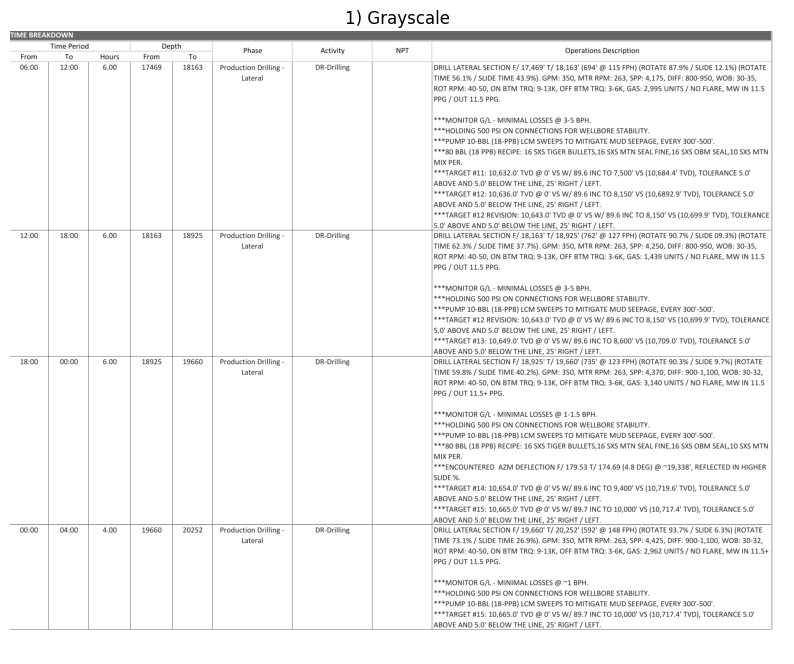

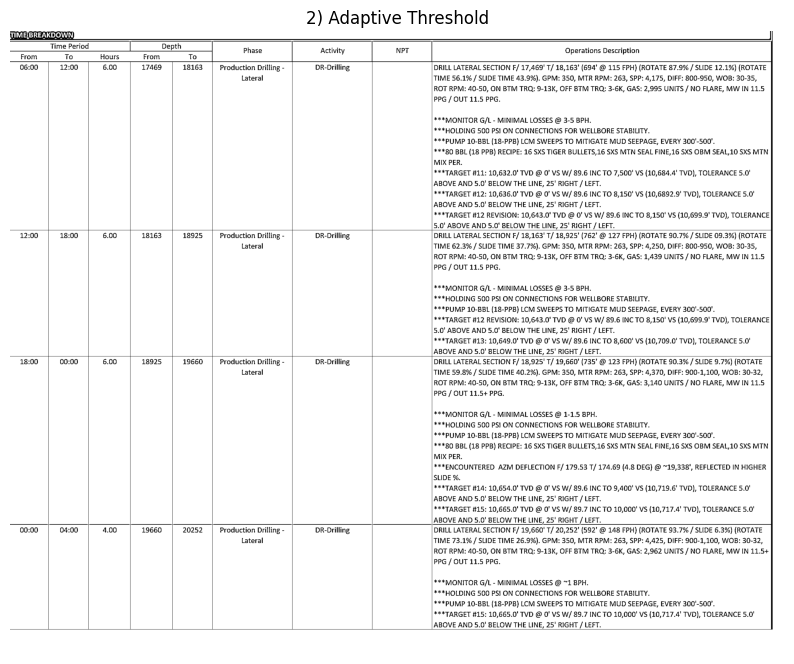

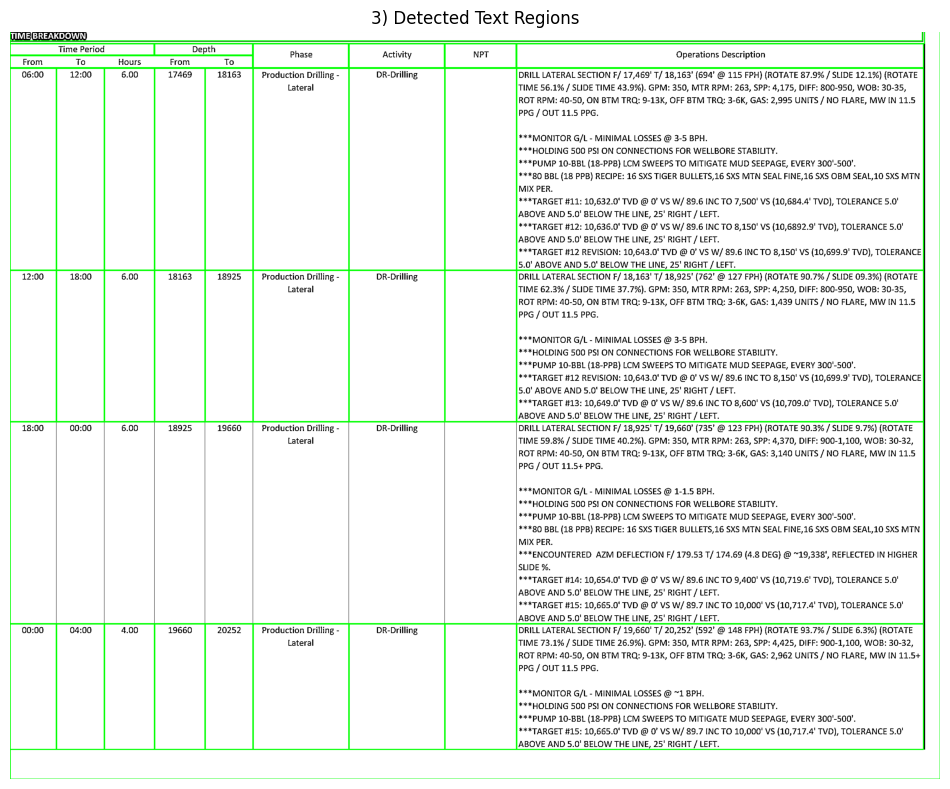

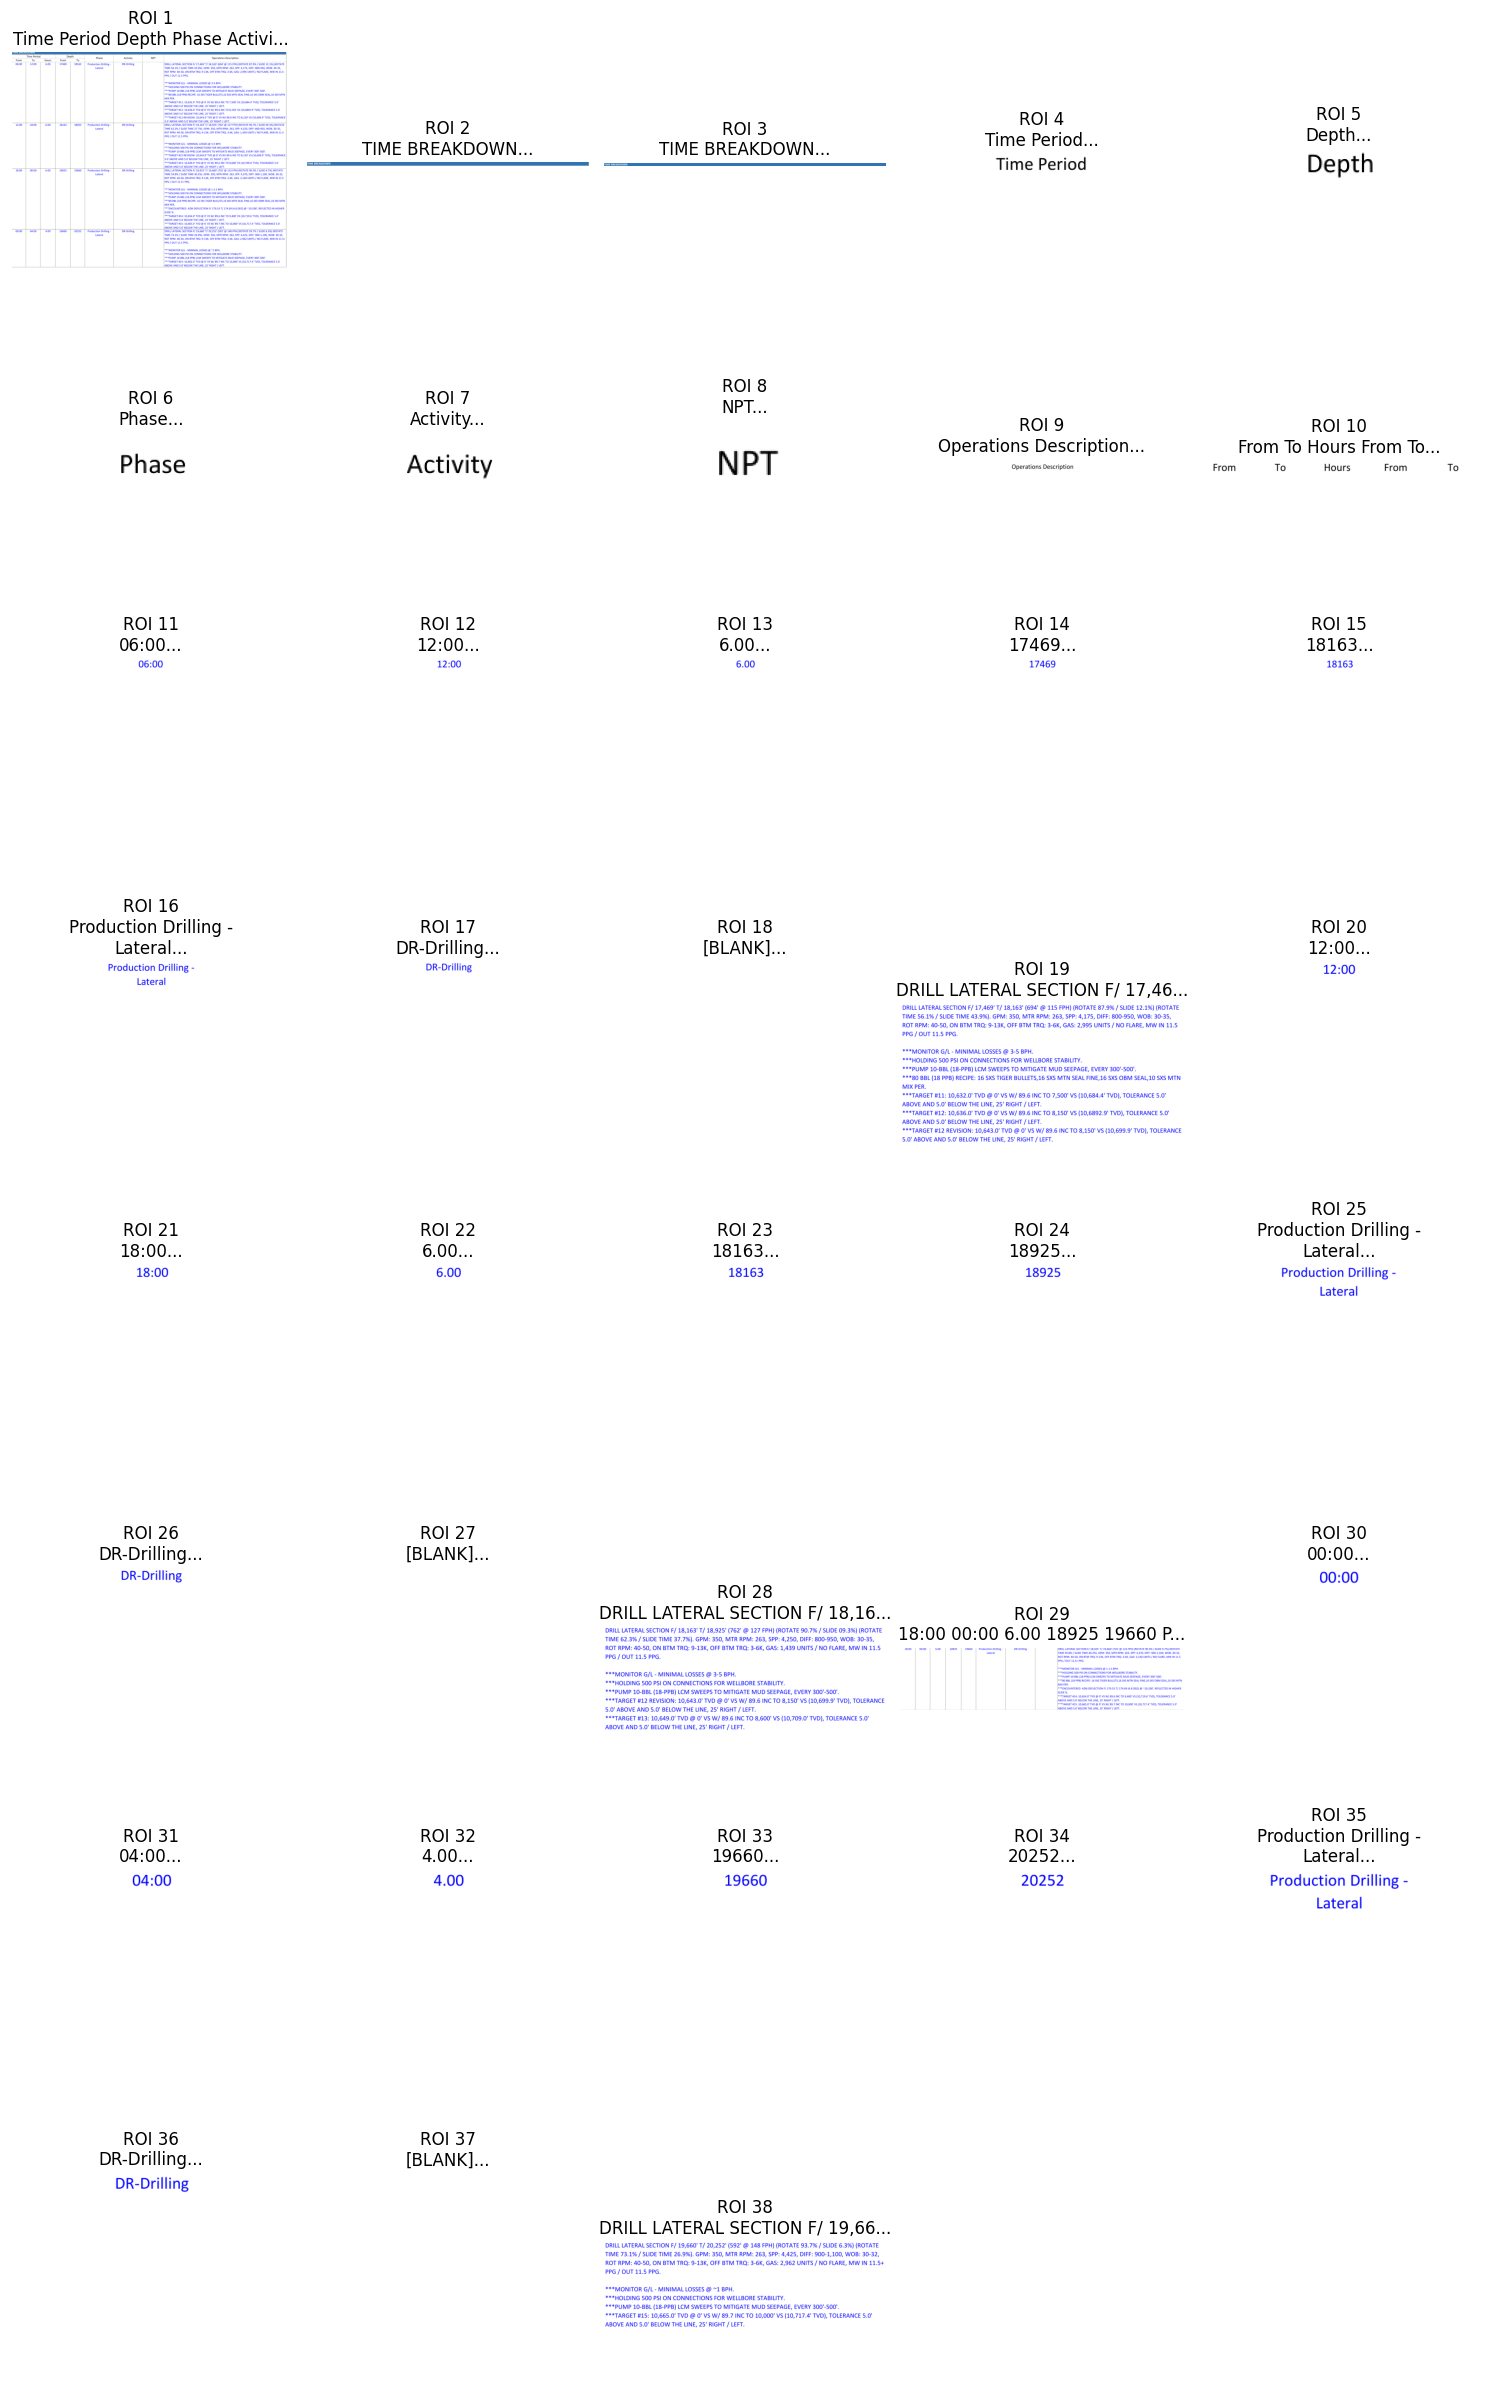

INFO: OCR results on detected regions:
INFO:timeBreakdownExtractor:OCR results on detected regions:
INFO: (0, 0, 2502, 2010, "Time Period Depth Phase Activity NPT Operations Description\nFrom To Hours From To\n06:00 12:00 6.00 17469 18163 Production Drilling - DR-Drilling DRILL LATERAL SECTION F/ 17,469' T/ 18,163' (694' @ 115 FPH) (ROTATE 87.9% / SLIDE 12.1%) (ROTATE\nLateral TIME 56.1% / SLIDE TIME 43.9%). GPM: 350, MTR RPM: 263, SPP: 4,175, DIFF: 800-950, WOB: 30-35,\nROT RPM: 40-50, ON BTM TRQ;: 9-13K, OFF BTM TRQ: 3-6K, GAS: 2,995 UNITS / NO FLARE, MW IN 11.5\nPPG / OUT 11.5 PPG.\n*** MONITOR G/L - MINIMAL LOSSES @ 3-5 BPH.\n***HOLDING 500 PSI ON CONNECTIONS FOR WELLBORE STABILITY.\n***PUMP 10-BBL (18-PPB) LCM SWEEPS TO MITIGATE MUD SEEPAGE, EVERY 300'-500'.\n***80 BBL (18 PPB) RECIPE: 16 SXS TIGER BULLETS, 16 SXS MTN SEAL FINE,16 SXS OBM SEAL,10 SXS MTN\nMIX PER.\n***TARGET #11: 10,632.0' TVD @ 0' VS W/ 89.6 INC TO 7,500' VS (10,684.4' TVD), TOLERANCE 5.0'\nABOVE AND 5.0' BELOW T

----- Extracted Time Breakdown DataFrame -----
    From  ...                Operations Description.Observations
0  06:00  ...  [MONITOR G/L - MINIMAL LOSSES @ 3-5 BPH., HOLD...
1  12:00  ...  [MONITOR G/L - MINIMAL LOSSES @ 3-5 BPH., HOLD...
2  18:00  ...  [MONITOR G/L - MINIMAL LOSSES @ 1-1.5 BPH., HO...
3  00:00  ...  [MONITOR G/L - MINIMAL LOSSES @ ~1 BPH., HOLDI...

[4 rows x 29 columns]


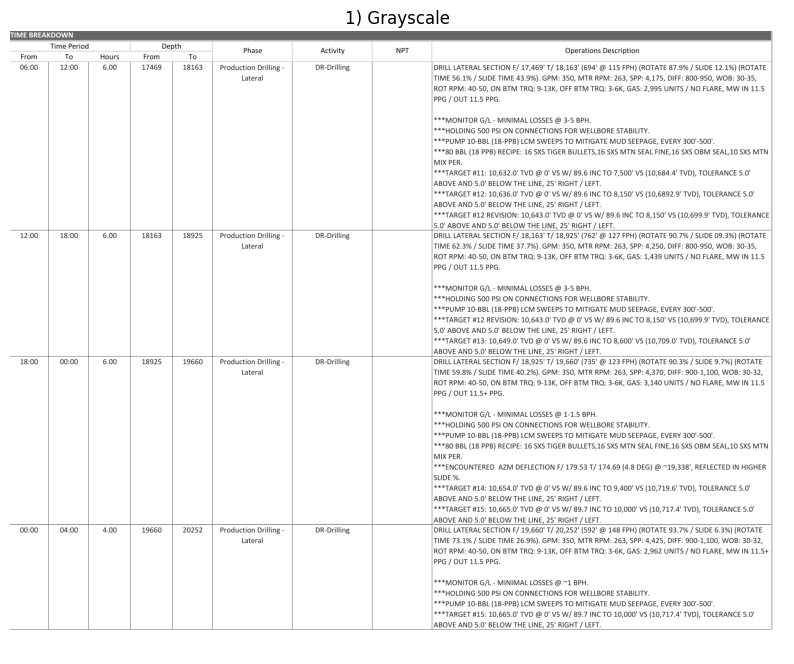

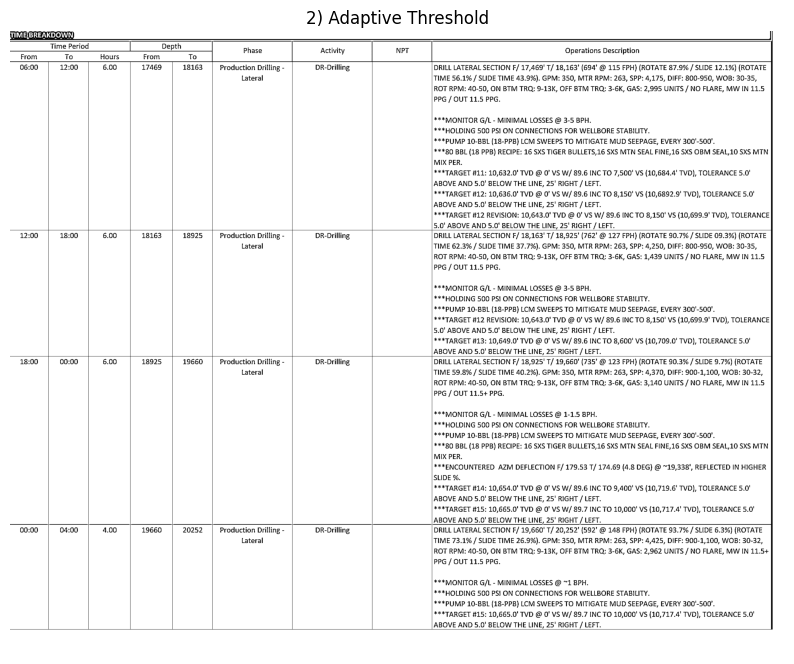

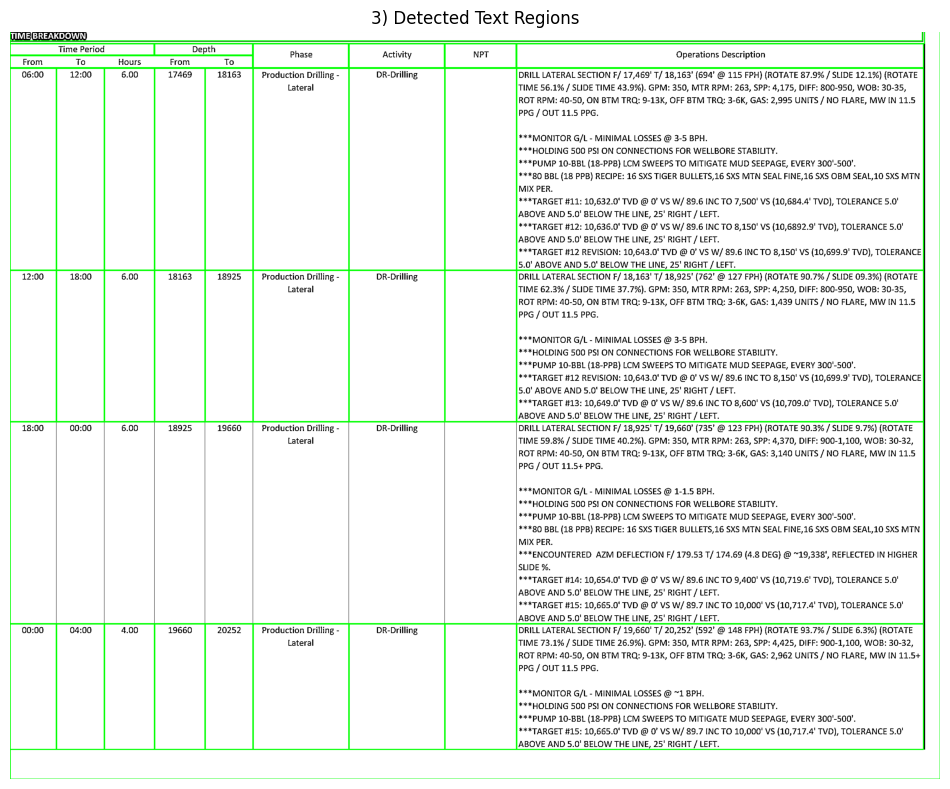

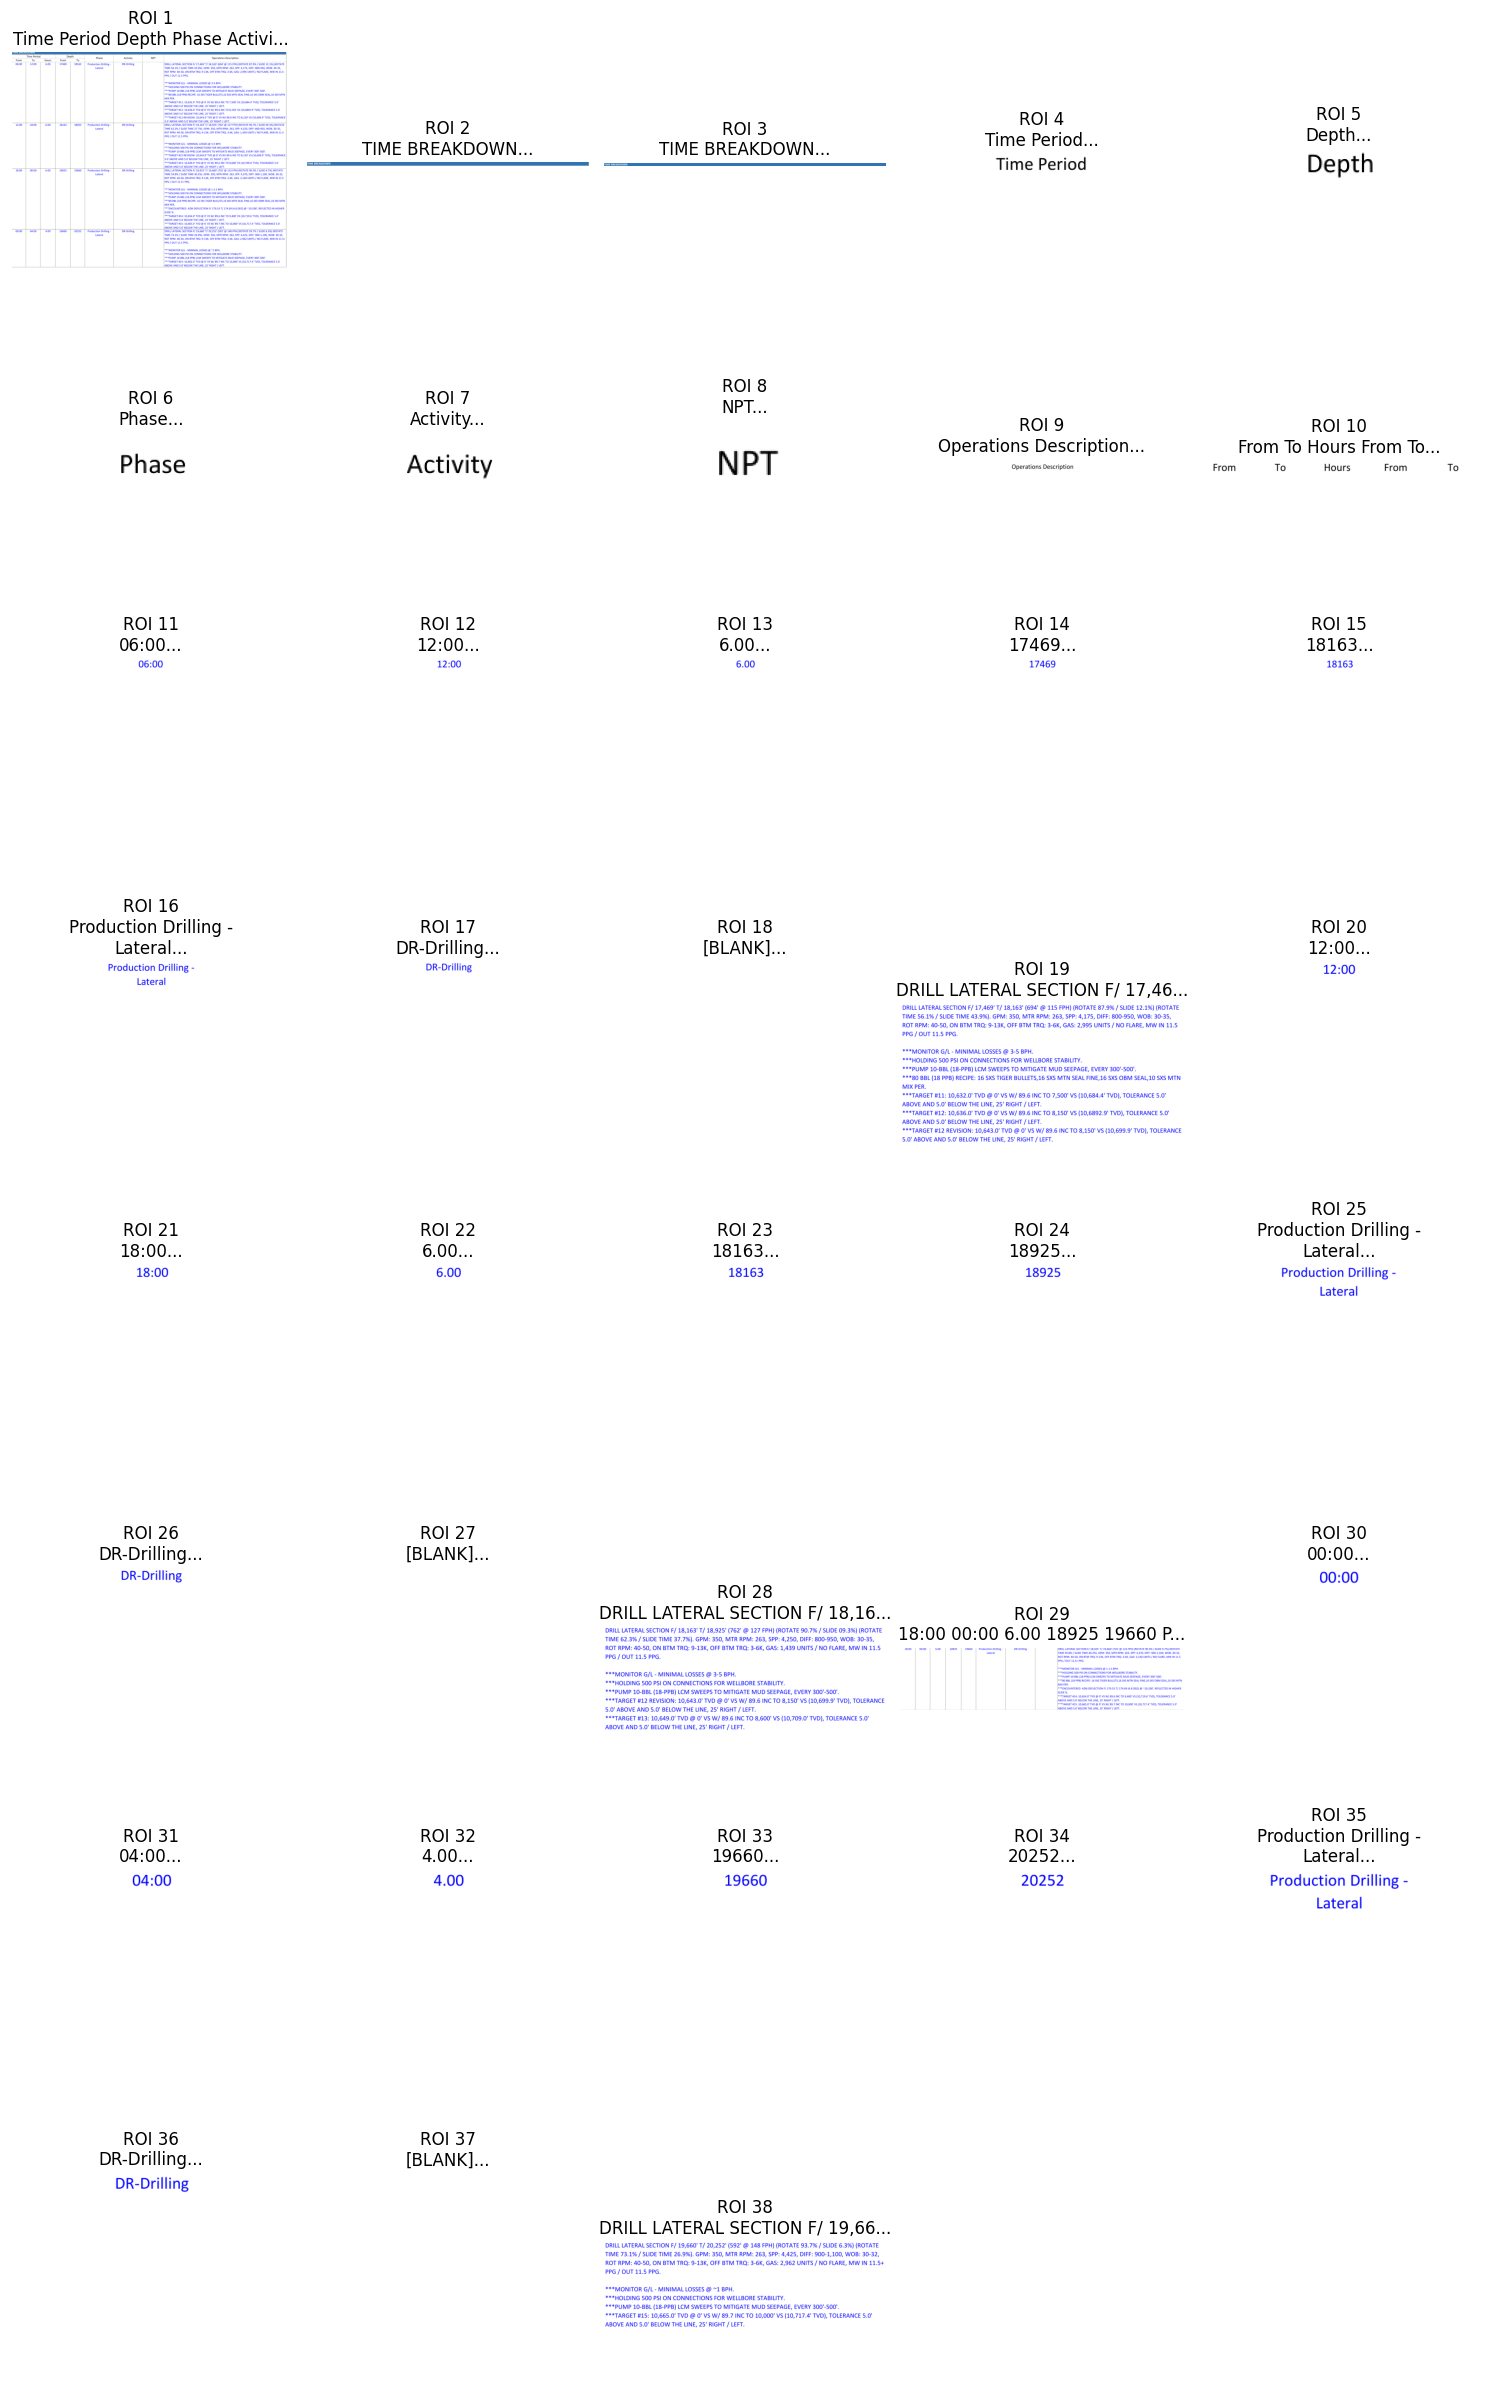

INFO: Trying to read image from: /dbfs/mnt/mini-proj-dd/cropped_sections/page_2_section_1.png
INFO:timeBreakdownExtractor:Trying to read image from: /dbfs/mnt/mini-proj-dd/cropped_sections/page_2_section_1.png


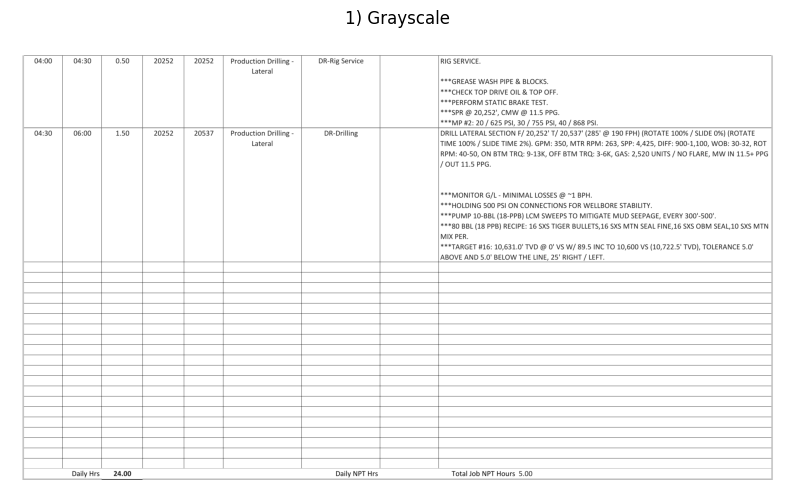

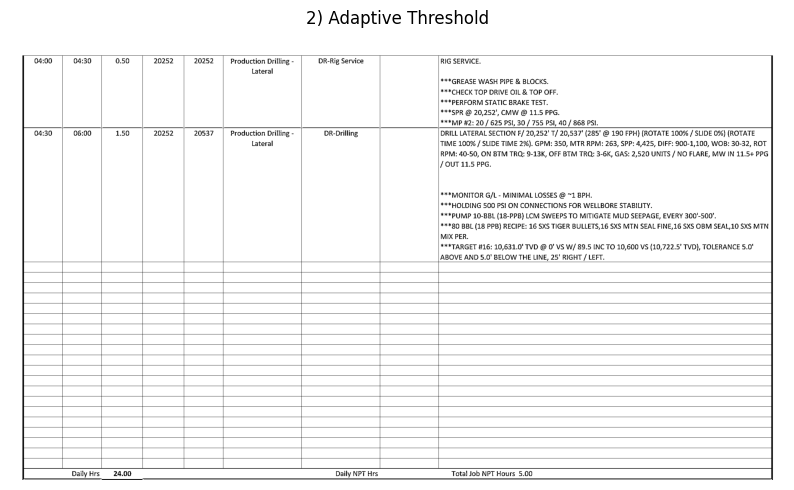

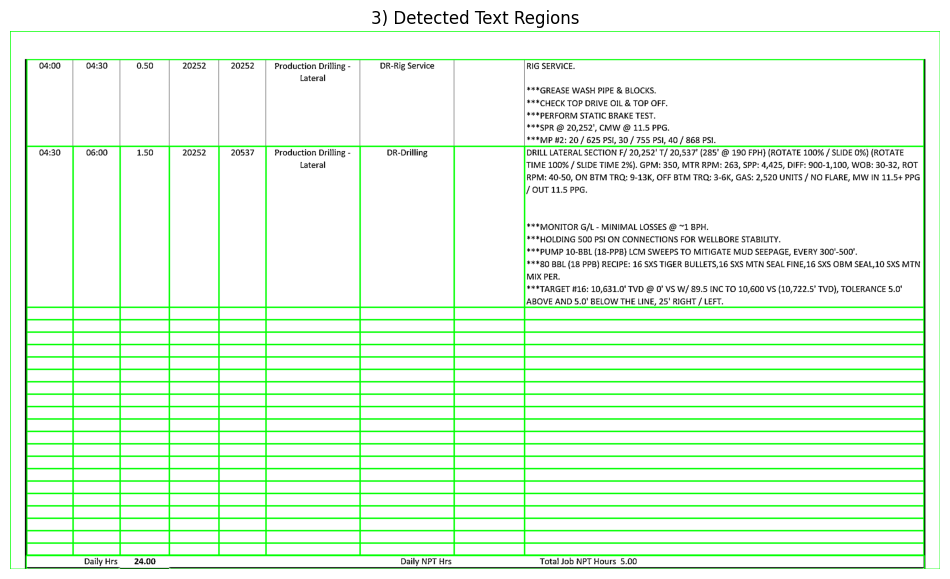

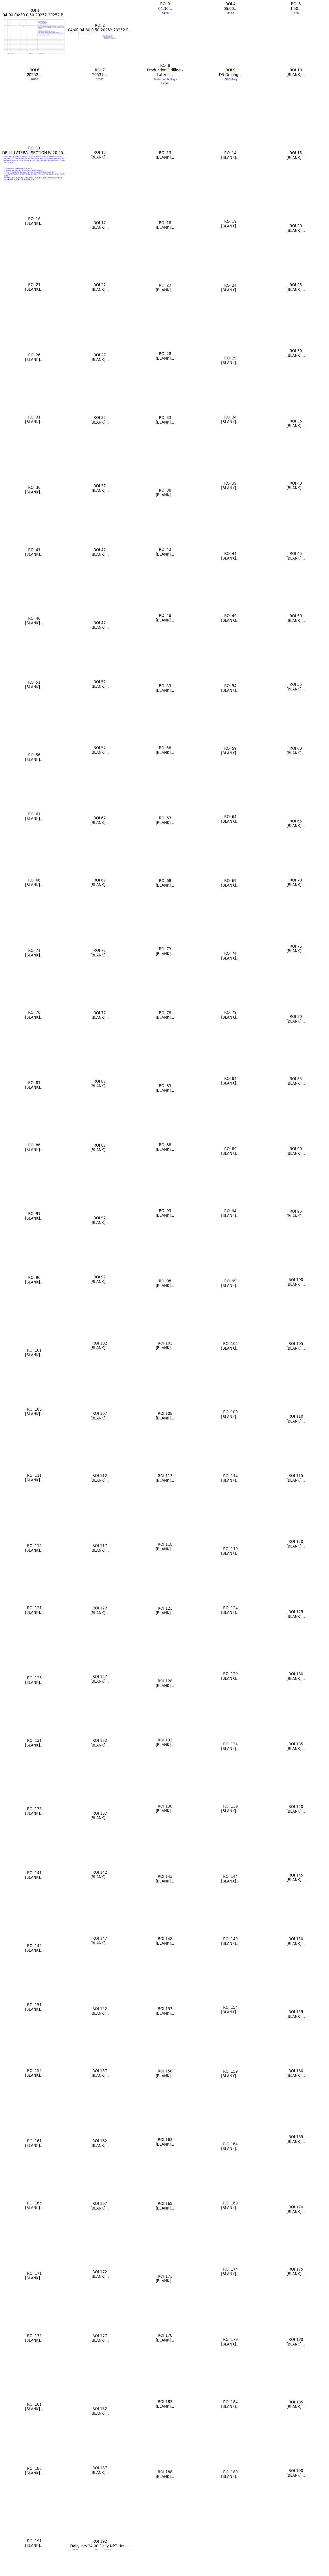

INFO: Skipping header or invalid row: [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK]
INFO:timeBreakdownExtractor:Skipping header or invalid row: [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK]
INFO: Skipping header or invalid row: [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK]
INFO:timeBreakdownExtractor:Skipping header or invalid row: [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK]
INFO: Skipping header or invalid row: [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK]
INFO:timeBreakdownExtractor:Skipping header or invalid row: [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK]
INFO: Skipping header or invalid row: [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK]
INFO:timeBreakdownExtractor:Skipping header or invalid row: [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK] [BLANK]
INFO: Skipping header or invalid

In [0]:

import os
import re
import cv2
import pytesseract
import numpy as np
import pandas as pd
import logging
import json
import math
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# Logger Setup
# ---------------------------------------------------------------------
logger = logging.getLogger("timeBreakdownExtractor")
logger.setLevel(logging.INFO)
if not logger.handlers:
    handler = logging.StreamHandler()
    handler.setFormatter(logging.Formatter("%(levelname)s: %(message)s"))
    logger.addHandler(handler)

# ---------------------------------------------------------------------
# Utility: show_image
# ---------------------------------------------------------------------
def show_image(title, img, cmap=None, size=(10,10)):
    plt.figure(figsize=size)
    if cmap:
        plt.imshow(img, cmap=cmap)
    else:
        if len(img.shape) == 3:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

# ---------------------------------------------------------------------
# safe_read_image: Read image from local or DBFS path
# ---------------------------------------------------------------------
def safe_read_image(img_path):
    if img_path.startswith("dbfs:"):
        local_path = img_path.replace("dbfs:", "/dbfs")
    else:
        local_path = img_path
    logger.info(f"Trying to read image from: {local_path}")
    if not os.path.exists(local_path):
        raise FileNotFoundError(f"File not found: {local_path}")
    img = cv2.imread(local_path)
    if img is None:
        raise FileNotFoundError(f"OpenCV failed to read the image: {local_path}")
    return img

# ---------------------------------------------------------------------
# preprocess_image: Convert to grayscale and apply adaptive thresholding
# ---------------------------------------------------------------------
def preprocess_image(img, debug=False):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if debug:
        show_image("1) Grayscale", gray, cmap="gray", size=(10,10))
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 15, 9)
    if debug:
        show_image("2) Adaptive Threshold", thresh, cmap="gray", size=(10,10))
    return thresh

# ---------------------------------------------------------------------
# detect_text_regions: Find contours and filter out small regions
# ---------------------------------------------------------------------
def detect_text_regions(thresh_img, debug=True):
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rois = []
    debug_img = cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2BGR)
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 30 and h > 15:
            rois.append((x, y, w, h))
            cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0,255,0), 2)
    rois.sort(key=lambda b: (b[1], b[0]))
    if debug:
        show_image("3) Detected Text Regions", debug_img, size=(12,12))
    return rois

# ---------------------------------------------------------------------
# perform_ocr_on_rois: Run OCR on each detected region
# ---------------------------------------------------------------------
def perform_ocr_on_rois(img, rois, debug=True):
    results = []
    n = len(rois)
    if debug and n > 0:
        cols = 5
        rows = math.ceil(n / cols)
        fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
        axes = axes.flatten() if rows > 1 else [axes]
    for i, (x, y, w, h) in enumerate(rois):
        roi = img[y:y+h, x:x+w]
        text = pytesseract.image_to_string(roi, config="--psm 6").strip()
        if not text:
            text = "[BLANK]"
        results.append((x, y, w, h, text))
        if debug and i < len(axes):
            roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
            axes[i].imshow(roi_rgb)
            axes[i].set_title(f"ROI {i+1}\n{text[:30]}...")
            axes[i].axis("off")
    if debug and n > 0:
        for j in range(i + 1, len(axes)):
            axes[j].axis("off")
        plt.tight_layout()
        plt.show()
    return results

# ---------------------------------------------------------------------
# Group OCR results into rows based on Y coordinate proximity
# ---------------------------------------------------------------------
def group_ocr_rows(roi_results, y_threshold=20):
    groups = []
    roi_results_sorted = sorted(roi_results, key=lambda r: r[1])
    current_group = []
    current_y = None
    for (x, y, w, h, text) in roi_results_sorted:
        if current_y is None:
            current_y = y
            current_group.append((x, y, w, h, text))
        elif abs(y - current_y) <= y_threshold:
            current_group.append((x, y, w, h, text))
        else:
            groups.append(current_group)
            current_group = [(x, y, w, h, text)]
            current_y = y
    if current_group:
        groups.append(current_group)
    return groups

# ---------------------------------------------------------------------
# parse_operations_description: Process the operations text into JSON
# ---------------------------------------------------------------------
def parse_operations_description(ops_text):
    ops_data = {
        "Depth": {"From": "", "To": ""},
        "Performance": {"Feet": "", "FPH": ""},
        "Rotation_Slide": {"Rotate": "", "Slide": ""},
        "Rotation_Time": {"Rotate Time": "", "Slide Time": ""},
        "GPM": "",
        "MTR RPM": "",
        "SPP": "",
        "DIFF": "",
        "WOB": "",
        "ROT RPM": "",
        "ON BTM TRQ": "",
        "OFF BTM TRQ": "",
        "GAS": {"Units": "", "Flare": ""},
        "MW": {"In": "", "Out": ""},
        "Targets": [],
        "Observations": []
    }
    depth_match = re.search(r"F/\s*([\d,']+)\s*T/\s*([\d,']+)", ops_text, re.IGNORECASE)
    if depth_match:
        ops_data["Depth"]["From"] = depth_match.group(1)
        ops_data["Depth"]["To"] = depth_match.group(2)
    perf_match = re.search(r"\(([\d,']+)\s*@\s*(\d+)\s*FPH\)", ops_text, re.IGNORECASE)
    if perf_match:
        ops_data["Performance"]["Feet"] = perf_match.group(1)
        ops_data["Performance"]["FPH"] = perf_match.group(2)
    rs_match = re.search(r"ROTATE\s*([\d.]+%)\s*/\s*SLIDE\s*([\d.]+%)", ops_text, re.IGNORECASE)
    if rs_match:
        ops_data["Rotation_Slide"]["Rotate"] = rs_match.group(1)
        ops_data["Rotation_Slide"]["Slide"] = rs_match.group(2)
    rt_match = re.search(r"ROTATE\s*TIME\s*([\d.]+%)\s*/\s*SLIDE\s*TIME\s*([\d.]+%)", ops_text, re.IGNORECASE)
    if rt_match:
        ops_data["Rotation_Time"]["Rotate Time"] = rt_match.group(1)
        ops_data["Rotation_Time"]["Slide Time"] = rt_match.group(2)
    # numeric_patterns = {
    #     "GPM": r"GPM:\s*(\d+)",
    #     "MTR RPM": r"MTR\s*RPM:\s*(\d+)",
    #     "SPP": r"SPP:\s*(\d+)",
    #     "DIFF": r"DIFF:\s*([\d\-]+)",
    #     "WOB": r"WOB:\s*(\d+)",
    #     "ROT RPM": r"ROT\s*RPM:\s*(\d+)",
    #     "ON BTM TRQ": r"ON\s*BTM\s*TRQ[:;]?\s*([\d\-K]+)",
    #     "OFF BTM TRQ": r"OFF\s*BTM\s*TRQ[:;]?\s*([\d\-K]+)"
    # }
    numeric_patterns = {
        "GPM": r"GPM:\s*(\d+)",
        "MTR RPM": r"MTR\s*RPM:\s*(\d+)",
        # For SPP, capture numbers with optional comma and/or a dash range (e.g., "4,175" or "4425-4500")
        "SPP": r"SPP:\s*([\d,]+(?:-\d+)?)(?:,|\s|$)",
        # For DIFF, unchanged if it works as is
        "DIFF": r"DIFF:\s*([\d\-]+)",
        # For WOB, capture a range like "30-40"
        "WOB": r"WOB:\s*([\d,]+(?:-\d+)?)(?:,|\s|$)",
        # For ROT RPM, capture a range like "40-45"
        "ROT RPM": r"ROT\s*RPM:\s*([\d,]+(?:-\d+)?)(?:,|\s|$)",
        "ON BTM TRQ": r"ON\s*BTM\s*TRQ[:;]?\s*([\d\-K]+)",
        "OFF BTM TRQ": r"OFF\s*BTM\s*TRQ[:;]?\s*([\d\-K]+)"
    }
    for key, pattern in numeric_patterns.items():
        m = re.search(pattern, ops_text, re.IGNORECASE)
        if m:
            ops_data[key] = m.group(1)
    gas_units = re.search(r"GAS:\s*([\d,]+)\s*UNITS", ops_text, re.IGNORECASE)
    if gas_units:
        ops_data["GAS"]["Units"] = gas_units.group(1)
    flare = re.search(r"(NO\s*FLARE|FLARE\s*ON|FLARE\s*\S+)", ops_text, re.IGNORECASE)
    if flare:
        ops_data["GAS"]["Flare"] = flare.group(1)
    mw_match = re.search(r"MW\s*IN\s*([\d.+]+)\s*PPG\s*/\s*OUT\s*([\d.+]+)\s*PPG", ops_text, re.IGNORECASE)
    if mw_match:
        ops_data["MW"]["In"] = mw_match.group(1)
        ops_data["MW"]["Out"] = mw_match.group(2)
    header_match = re.search(r".*MW\s*IN\s*[\d.+]+\s*PPG\s*/\s*OUT\s*[\d.+]+\s*PPG\.", ops_text, re.IGNORECASE)
    if header_match:
        residual = ops_text[header_match.end():]
    else:
        residual = ops_text
    segments = re.split(r'(?=\*\*\*)', residual)
    obs_list = []
    for seg in segments:
        seg = seg.strip()
        if not seg:
            continue
        if not seg.startswith('***'):
            parts = [p.strip() for p in seg.split('.') if p.strip()]
            obs_list.extend(parts)
        else:
            obs_list.append(seg)

    # Clean up each observation and remove leading asterisks
    obs_list = [o.lstrip('* ').strip() for o in obs_list]

    # Filter out TARGET lines from observations
    clean_obs = [o for o in obs_list if "TARGET" not in o.upper()]

    # Build targets list based on the original obs_list (if needed)
    targets = [o for o in obs_list if "TARGET" in o.upper()]
    targets = [t.lstrip('* ').strip() for t in targets]

    ops_data["Observations"] = clean_obs
    ops_data["Targets"] = targets

    return ops_data

# ---------------------------------------------------------------------
# parse_row_text: Parse a single row of OCR text into JSON keys
# ---------------------------------------------------------------------
def parse_row_text(row_text):
    # Clean up whitespace and newlines
    clean_text = " ".join(row_text.split())
    
    # Special handling for Daily Summary rows
    if "Daily Hrs" in clean_text:
        # Expecting a row like:
        # "Daily Hrs 24.00 Daily NPT Hrs Total Job NPT Hours 5.00"
        pattern = r"Daily Hrs\s+(\S+)\s+Daily NPT Hrs\s*(\S*)\s+Total Job NPT Hours\s+(\S+)"
        m = re.search(pattern, clean_text, re.IGNORECASE)
        if m:
            return {
                "Daily Summary": {
                    "Daily Hrs": m.group(1),
                    "Daily NPT Hrs": m.group(2),
                    "Total Job NPT Hours": m.group(3)
                }
            }
        else:
            logger.warning(f"Daily summary row detected but could not parse: {clean_text}")
            return None

    # Skip rows that do not start with a valid time (avoid headers)
    tokens = clean_text.split()
    if not tokens or not re.match(r"\d{2}:\d{2}", tokens[0]):
        logger.info(f"Skipping header or invalid row: {clean_text}")
        return None

    # Expect at least 8 tokens for a valid data row
    if len(tokens) < 8:
        logger.warning(f"Row does not have enough tokens: {clean_text}")
        return None

    # Standard extraction for valid data rows
    from_time = tokens[0]
    to_time = tokens[1]
    hours = tokens[2]
    depth_start = tokens[3]
    depth_end = tokens[4]
    
    # Process the remainder for Phase, Activity, and Operations Description.
    header_rest = " ".join(tokens[5:])
    m = re.search(r"^(?P<phase>.+?)\s+(?P<activity>DR[-]?Drilling)\s+(?P<ops>.*)$", header_rest, re.IGNORECASE)
    if m:
        phase = m.group("phase")
        activity = m.group("activity")
        ops = m.group("ops")
    else:
        phase = tokens[5]
        activity = tokens[6] if len(tokens) > 6 else ""
        ops = " ".join(tokens[7:]) if len(tokens) > 7 else ""
    
    return {
        "From": from_time,
        "To": to_time,
        "Hours": hours,
        "Depth Start": depth_start,
        "Depth End": depth_end,
        "Phase": phase,
        "Activity": activity,
        "Operations Description": parse_operations_description(ops)
    }


# ---------------------------------------------------------------------
# parse_all_rows_from_text: Fallback method using full OCR text
# ---------------------------------------------------------------------
def parse_all_rows_from_text(full_text):
    if re.search(r"\d{2}:\d{2}\s+\d{2}:\d{2}", full_text):
        row_chunks = re.split(r"(?=\d{2}:\d{2}\s+\d{2}:\d{2})", full_text)
        rows = []
        for chunk in row_chunks:
            chunk = chunk.strip()
            if not chunk:
                continue
            row = parse_row_text(chunk)
            if row:
                rows.append(row)
        return rows
    else:
        fallback_row = {
            "From": "",
            "To": "",
            "Hours": "",
            "Depth Start": "",
            "Depth End": "",
            "Phase": "",
            "Activity": "",
            "Operations Description": parse_operations_description(full_text)
        }
        return [fallback_row]

# ---------------------------------------------------------------------
# parse_all_rows_from_ocr_groups: Group OCR cells and parse each row
# ---------------------------------------------------------------------

def parse_all_rows_from_ocr_groups(roi_results):
    rows = []
    groups = group_ocr_rows(roi_results, y_threshold=20)
    for group in groups:
        group_sorted = sorted(group, key=lambda r: r[0])
        row_text = " ".join([text for (x, y, w, h, text) in group_sorted])
        # Skip header labels if present
        if any(kw in row_text.upper() for kw in ["TIME PERIOD", "FROM TO", "DEPTH PHASE", "OPERATIONS DESCRIPTION"]):
            continue
        parsed_row = parse_row_text(row_text)
        if parsed_row:  # only add if not None
            rows.append(parsed_row)
    return rows

# ---------------------------------------------------------------------
# main_time_breakdown_pipeline: Orchestrates the full pipeline
# ---------------------------------------------------------------------

def main_time_breakdown_pipeline():
    # Set the image path (modify if needed)
    img_path = "dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_14.png"
    try:
        img = safe_read_image(img_path)
        logger.info("Image loaded successfully.")
    except Exception as e:
        logger.error(e)
        return

    # Preprocess image and detect text regions
    thresh_img = preprocess_image(img, debug=True)
    rois = detect_text_regions(thresh_img, debug=True)
    
    # Perform OCR on each detected region
    roi_ocr_results = perform_ocr_on_rois(img, rois, debug=True)
    logger.info("OCR results on detected regions:")
    for roi_result in roi_ocr_results:
        logger.info(roi_result)
    
    # First, try grouping OCR boxes and parsing each row
    time_breakdown_list = parse_all_rows_from_ocr_groups(roi_ocr_results)
    if not time_breakdown_list:
        logger.warning("No rows detected from ROI grouping. Falling back to full-image OCR.")
        full_text = pytesseract.image_to_string(thresh_img, config="--psm 6")
        time_breakdown_list = parse_all_rows_from_text(full_text)
    
    if not time_breakdown_list:
        logger.error("No rows were detected. Please check the OCR output and header format.")
        return

    # Build final JSON output in the desired structure
    final_output = {"TIME BREAKDOWN": time_breakdown_list}
    logger.info("===== FINAL TIME BREAKDOWN DATA =====")
    logger.info(json.dumps(final_output, indent=4))

    # Create a DataFrame for visualization and further use
    df = pd.json_normalize(final_output["TIME BREAKDOWN"])
    print("----- Extracted Time Breakdown DataFrame -----")
    print(df)

    # Save JSON and CSV results to the specified output folder
    output_folder = "dbfs:/mnt/mini-proj-dd/final_time_breakdown_results"
    local_folder = output_folder.replace("dbfs:", "/dbfs")
    os.makedirs(local_folder, exist_ok=True)
    out_json = os.path.join(local_folder, "time_breakdown_data.json")
    with open(out_json, "w") as f:
        json.dump(final_output, f, indent=4)
    logger.info(f"JSON saved to {out_json}")
    out_csv = os.path.join(local_folder, "time_breakdown_data.csv")
    df.to_csv(out_csv, index=False)
    logger.info(f"CSV saved to {out_csv}")

if __name__ == "__main__":
    main_time_breakdown_pipeline()


def merge_time_breakdown_data(main_data, continuation_data):
    """
    Merge two lists of time breakdown rows.
    Assumes continuation_data does not include header rows.
    """
    # Simply concatenate the two lists.
    # Optionally, you could add logic here to validate or sort the merged data.
    return main_data + continuation_data
def process_time_breakdown_image(img_path, debug=False):
    # Load image, preprocess, perform OCR, and parse rows as before.
    img = safe_read_image(img_path)
    thresh_img = preprocess_image(img, debug=debug)
    rois = detect_text_regions(thresh_img, debug=debug)
    roi_ocr_results = perform_ocr_on_rois(img, rois, debug=debug)
    rows = parse_all_rows_from_ocr_groups(roi_ocr_results)
    if not rows:
        full_text = pytesseract.image_to_string(thresh_img, config="--psm 6")
        rows = parse_all_rows_from_text(full_text)
    return rows

# Process first page with header.
main_data = process_time_breakdown_image("dbfs:/mnt/mini-proj-dd/cropped_sections/page_1_section_14.png", debug=True)

# Process continuation page (without header).
continuation_data = process_time_breakdown_image("dbfs:/mnt/mini-proj-dd/cropped_sections/page_2_section_1.png", debug=True)

# Merge both sets.
merged_data = merge_time_breakdown_data(main_data, continuation_data)

# Build final JSON output.
final_output = {"TIME BREAKDOWN": merged_data}

In [0]:
final_output

{'TIME BREAKDOWN': [{'From': '06:00',
   'To': '12:00',
   'Hours': '6.00',
   'Depth Start': '17469',
   'Depth End': '18163',
   'Phase': 'Production Drilling - Lateral',
   'Activity': 'DR-Drilling',
   'Operations Description': {'Depth': {'From': "17,469'", 'To': "18,163'"},
    'Performance': {'Feet': "694'", 'FPH': '115'},
    'Rotation_Slide': {'Rotate': '87.9%', 'Slide': '12.1%'},
    'Rotation_Time': {'Rotate Time': '56.1%', 'Slide Time': '43.9%'},
    'GPM': '350',
    'MTR RPM': '263',
    'SPP': '4,175,',
    'DIFF': '800-950',
    'WOB': '30-35',
    'ROT RPM': '40-50',
    'ON BTM TRQ': '9-13K',
    'OFF BTM TRQ': '3-6K',
    'GAS': {'Units': '2,995', 'Flare': 'NO FLARE'},
    'MW': {'In': '11.5', 'Out': '11.5'},
    'Targets': ["TARGET #11: 10,632.0' TVD @ 0' VS W/ 89.6 INC TO 7,500' VS (10,684.4' TVD), TOLERANCE 5.0° ABOVE AND 5.0' BELOW THE LINE, 25' RIGHT / LEFT.",
     "TARGET #12: 10,636.0' TVD @ 0' VS W/ 89.6 INC TO 8,150' VS (10,6892.9' TVD), TOLERANCE 5.0° ABOVE 